# **Setup**

## Libraries

In [1]:
import argparse
import os
import sys
from functools import partial
from tqdm import tqdm
import json
from types import SimpleNamespace

import pyrootutils
import dgl
import dgl.function as fn
import hydra
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import MeanMetric
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import BinaryAUROC, BinaryAveragePrecision
from sklearn import metrics

import pandas as pd
import scipy.stats as st
from IPython.display import clear_output

/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [2]:
# Simulate having cfg available by loading in hydra config as dict
import yaml
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

## User Definition

In [3]:
user_net_id = os.getlogin()
home_path = '/scratch/' + user_net_id + '/projects/NYU-Zillow-Capstone-2022-Team-A'
if home_path not in sys.path:
    sys.path.append('/scratch/' + user_net_id + '/projects/NYU-Zillow-Capstone-2022-Team-A')

from src.datamodules.negative_sampler import NegativeSampler
from src.model.SAGE import SAGE

# **Modules**

## Graph Generation

In [4]:
def to_bidirected_with_reverse_mapping(g):
    """Makes a graph bidirectional, and returns a mapping array ``mapping`` where ``mapping[i]``
    is the reverse edge of edge ID ``i``. Does not work with graphs that have self-loops.
    """
    g_simple, mapping = dgl.to_simple(
        dgl.add_reverse_edges(g), return_counts="count", writeback_mapping=True
    )
    c = g_simple.edata["count"]
    num_edges = g.num_edges()
    mapping_offset = torch.zeros(g_simple.num_edges() + 1, dtype=g_simple.idtype)
    mapping_offset[1:] = c.cumsum(0)
    idx = mapping.argsort()
    idx_uniq = idx[mapping_offset[:-1]]
    reverse_idx = torch.where(
        idx_uniq >= num_edges, idx_uniq - num_edges, idx_uniq + num_edges
    )
    reverse_mapping = mapping[reverse_idx]
    # sanity check
    src1, dst1 = g_simple.edges()
    src2, dst2 = g_simple.find_edges(reverse_mapping)
    assert torch.equal(src1, dst2)
    assert torch.equal(src2, dst1)
    return g_simple, reverse_mapping


class NegativeSamplerTest(object):
    def __init__(self, g, k, max_img_id, keyword_as_src, neg_share=False):
        self.weights = g.in_degrees().float() ** 0.75
        self.k = k
        self.neg_share = neg_share
        self.max_img_id = max_img_id
        self.keyword_as_src = keyword_as_src

    def __call__(self, g, eids):
        src, _ = g.find_edges(eids)
        if self.keyword_as_src == False:
            img_node_mask = src <= self.max_img_id
            src = src[img_node_mask]
        n = len(src)

        if self.neg_share and n % self.k == 0:
            dst = self.weights.multinomial(n, replacement=True)
            dst = dst.view(-1, 1, self.k).expand(-1, self.k, -1).flatten()
        else:
            dst = self.weights.multinomial(n * self.k, replacement=True)
            
        src = src.repeat_interleave(self.k)
        return src, dst

class DataModule(LightningDataModule):
    def __init__(
        self,
        csv_dataset_root,
        modal_node_ids_file,
        keyword_as_src=False,
        data_cpu=False,
        fan_out=[10, 25, 40],
        device="cpu",
        batch_size=1024,
        num_workers=4,
        force_reload=False,
    ):
        super().__init__()
        self.save_hyperparameters()
        dataset = dgl.data.CSVDataset(csv_dataset_root, force_reload=force_reload)
        g = dataset[0]
        g_bid, reverse_eids = to_bidirected_with_reverse_mapping(g)
        g_bid = g_bid.to(device)
        g = g.to(device)
        reverse_eids = reverse_eids.to(device)

        max_img_id = max(json.load(open(modal_node_ids_file, 'r'))['images'])

        train_nid = torch.nonzero(g_bid.ndata["train_mask"], as_tuple=True)[0].to(device)
        val_nid = torch.nonzero(g_bid.ndata["val_mask"], as_tuple=True)[0].to(device)
        test_nid = torch.nonzero(g_bid.ndata["test_mask"], as_tuple=True)[0].to(device)

        sampler = dgl.dataloading.MultiLayerNeighborSampler(
            [int(_) for _ in fan_out], prefetch_node_feats=["feat"]
        )

        self.g = g
        self.g_bid = g_bid
        self.train_nid = train_nid
        self.val_nid = torch.cat((val_nid, test_nid))
        self.test_nid = test_nid
        self.sampler = sampler
        self.device = device
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.in_dim = g_bid.ndata["feat"].shape[1]
        self.reverse_eids = reverse_eids
        self.max_img_id = max_img_id
        self.keyword_as_src = keyword_as_src


    def train_dataloader(self):
        edge_sampler = dgl.dataloading.as_edge_prediction_sampler(
            self.sampler,
            exclude='reverse_id',
            reverse_eids=self.reverse_eids,
            negative_sampler=NegativeSamplerTest(self.g, 1, self.max_img_id, self.keyword_as_src)
        )

        train_subgraph = self.g_bid.subgraph(self.train_nid)
        train_u, train_v = train_subgraph.edges()
        train_eids = train_subgraph.edata['_ID'][train_subgraph.edge_ids(train_u, train_v)]

        return dgl.dataloading.DataLoader(
            self.g_bid,
            train_eids,
            edge_sampler,
            device=self.device,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False
        )

    def val_dataloader(self):
        edge_sampler = dgl.dataloading.as_edge_prediction_sampler(
            self.sampler,
        )

        val_subgraph = self.g_bid.subgraph(self.val_nid)
        val_u, val_v = val_subgraph.edges()
        val_eids = val_subgraph.edata['_ID'][val_subgraph.edge_ids(val_u, val_v)]

        return dgl.dataloading.DataLoader(
            self.g_bid,
            val_eids,
            edge_sampler,
            device=self.device,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False
        )

## Model Infrastructure

In [5]:
class ScorePredictor(nn.Module):
    def forward(self, edge_subgraph, x):
        with edge_subgraph.local_scope():
            edge_subgraph.ndata["h"] = x
            edge_subgraph.ndata['h_norm'] = F.normalize(x, p=2, dim=-1)
            edge_subgraph.apply_edges(fn.u_dot_v("h_norm", "h_norm", "score"))
            return edge_subgraph.edata["score"]

class SAGELightning(LightningModule):
    def __init__(
        self,
        in_dim,
        h_dim,
        n_layers=3,
        activation=F.relu,
        dropout=0,
        sage_conv_method="mean",
        lr=0.0005,
        batch_size=1024,
    ):
        super().__init__()
        self.module = SAGE(
            in_dim, h_dim, n_layers, activation, dropout, sage_conv_method
        )
        self.lr = lr
        self.predictor = ScorePredictor()
        self.batch_size = batch_size
        self.save_hyperparameters()

        self.train_loss = MeanMetric()
        self.mean_val_positive_score = MeanMetric()
    
    def forward(self, graph, blocks, x):
        self.module(graph, blocks, x)

    def training_step(self, batch, batch_idx):
        input_nodes, pos_graph, neg_graph, blocks = batch
        x = blocks[0].srcdata["feat"]
        logits = self.module(blocks, x)
        pos_score = self.predictor(pos_graph, logits)
        neg_score = self.predictor(neg_graph, logits)

        score = torch.cat([pos_score, neg_score])
        pos_label = torch.ones_like(pos_score)
        neg_label = torch.zeros_like(neg_score)
        labels = torch.cat([pos_label, neg_label])
        loss = F.binary_cross_entropy_with_logits(score, labels)

        return loss

    def validation_step(self, batch, batch_idx):
        input_nodes, pos_graph, blocks = batch
        x = blocks[0].srcdata["feat"]
        logits = self.module(blocks, x)
        pos_score = self.predictor(pos_graph, logits)
        pos_label = torch.ones_like(pos_score)
        self.mean_val_positive_score(pos_score)

        self.log(
            "mean_val_positive_score",
            self.mean_val_positive_score,
            prog_bar=True,
            on_step=False,
            on_epoch=True,
            batch_size=self.batch_size,
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

# **Notebook Run - Preperation**

## Directory Definition

In [6]:
class NestedNamespace(SimpleNamespace):
    def __init__(self, dictionary, **kwargs):
        super().__init__(**kwargs)
        for key, value in dictionary.items():
            if isinstance(value, dict):
                self.__setattr__(key, NestedNamespace(value))
            else:
                self.__setattr__(key, value)

root_path = pyrootutils.find_root(search_from='train_graphsage_explore.ipynb', indicator=".git")
print('Set WD location to', root_path)
pyrootutils.set_root(
    path=root_path,
    project_root_env_var=True,
    dotenv=True,
    pythonpath=True,
    cwd=True
)

Set WD location to /scratch/aks9136/projects/NYU-Zillow-Capstone-2022-Team-A


## CUDA

In [9]:
'''
try:
    if not torch.cuda.is_available():
        device = "cpu"
        print('No GPU available, using CPU')
    else:
        device = "cuda"
        print('Using GPU')
except:
    device = "cpu"
    print('No GPU available, using CPU')
'''

device = 'cuda'

# **Notebook Run**

## Select reconnection method

In [22]:
reconnection_method = 'scene'
# reconnection_method = 'cosine'

## Graph Training

In [23]:
# Vanilla Graph Training
cfg = NestedNamespace(yaml.load(open('conf/config.yaml'), Loader=Loader))
org = 'zillow'
pre_connect_threshold = 0.975
connect_type = f'_images_{str(pre_connect_threshold).split(".")[-1]}' if reconnection_method in ['cosine', 'scene'] else ''

if org == 'coco':
    csv_dataset_root = cfg.data.coco_graph_root
elif org == 'zillow':
    csv_dataset_root = cfg.data.zillow_graph_root + connect_type

modal_node_ids_file = os.path.join(csv_dataset_root,'modal_node_ids.json')
datamodule = DataModule(
    csv_dataset_root, 
    modal_node_ids_file, 
    keyword_as_src=False, 
    device=device, 
    batch_size=cfg.training.batch_size, 
    force_reload=False
)

model = SAGELightning(
    datamodule.in_dim,
    cfg.model.hidden_dim,
    n_layers=cfg.model.n_layers,
    batch_size=cfg.training.batch_size,
    lr=cfg.training.learning_rate
)

checkpoint_callback = ModelCheckpoint(
    monitor="mean_val_positive_score", save_top_k=1, mode="max"
)

trainer = Trainer(accelerator="cpu", max_epochs=cfg.training.n_epochs, callbacks=[checkpoint_callback])
trainer.fit(model, datamodule=datamodule)

Done loading data from cached files.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type           | Params
-----------------------------------------------------------
0 | module                  | SAGE           | 1.6 M 
1 | predictor               | ScorePredictor | 0     
2 | train_loss              | MeanMetric     | 0     
3 | mean_val_positive_score | MeanMetric     | 0     
-----------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.298     Total estimated model params size (MB)


/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:135: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(
/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 160 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/lightning_lite/utilities/data.py:63: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurat

Epoch 4: 100%|██████████| 688/688 [00:47<00:00, 14.33it/s, loss=0.533, v_num=485, mean_val_positive_score=0.907]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 688/688 [00:47<00:00, 14.33it/s, loss=0.533, v_num=485, mean_val_positive_score=0.907]


## Reconnecting Train and Val Subgraphs

##### Initialize Val and Eval Subgraphs

In [24]:
# Step 1: Initialize val and eval subgraph
val_subgraph = datamodule.g_bid.subgraph(datamodule.val_nid)
eval_subgraph = datamodule.g_bid.subgraph(datamodule.train_nid)

##### Combine Nodes Only (No Edges)

In [25]:
val_img_node_idxs = (val_subgraph.ndata['ntype'] == 0).nonzero().squeeze()
val_img_embeds = val_subgraph.ndata['feat'][val_img_node_idxs]
val_img_node_ids = val_subgraph.ndata['_ID'][val_img_node_idxs]

print('number of val img nodes:', len(val_img_node_ids))
print('number of train img nodes:', len(eval_subgraph.nodes()))

val_nodes_data = {'train_mask': torch.zeros(len(val_img_node_ids), dtype=torch.uint8).to(device),
                  'val_mask': torch.ones(len(val_img_node_ids), dtype=torch.uint8).to(device),
                  'test_mask': torch.zeros(len(val_img_node_ids), dtype=torch.uint8).to(device),
                  'ntype': torch.zeros(len(val_img_node_ids), dtype=torch.int64).to(device),
                  'feat': val_img_embeds.to(device),
                  '_ID': val_img_node_ids}

eval_subgraph.add_nodes(num=len(val_img_node_ids), data=val_nodes_data)

number of val img nodes: 25087
number of train img nodes: 59183


##### Identify Node Pairs as Potential Edges

Method: Cosine

In [26]:
################################################
## Reconnection Type : COSINE ##################
## Finding Img-Any Training Node Pairs #########
################################################

def cosine_sim(a, b):
    a = F.normalize(a, p=2, dim=-1)
    b = F.normalize(b, p=2, dim=-1)

    try:
        return a @ b.T
    except:
        print('Matrix multiplication failed. Check dimensions.')


if reconnection_method == 'cosine':
    # Step 3: Identify image node pairs as edges

    eval_train_img_node_idxs = ((eval_subgraph.ndata['ntype'] == 0)&(eval_subgraph.ndata['train_mask']==1)).nonzero().squeeze()
    eval_train_kw_node_idxs = ((eval_subgraph.ndata['ntype'] == 1)&(eval_subgraph.ndata['train_mask']==1)).nonzero().squeeze()
    eval_val_img_node_idxs = ((eval_subgraph.ndata['ntype'] == 0)&(eval_subgraph.ndata['val_mask']==1)).nonzero().squeeze()
    
    eval_train_img_embeds = eval_subgraph.ndata['feat'][eval_train_img_node_idxs]
    eval_train_kw_embeds = eval_subgraph.ndata['feat'][eval_train_kw_node_idxs]
    eval_val_img_embeds = eval_subgraph.ndata['feat'][eval_val_img_node_idxs]

    cosine_sims_img_matrix = cosine_sim(eval_val_img_embeds, eval_train_img_embeds)
    cosine_sims_img_kw_matrix = cosine_sim(eval_val_img_embeds, eval_train_kw_embeds)

    img_sim_threshold = 0.98
    img_img_k = 5
    img_kw_k = 5
            
    matches = []
    for i in tqdm(range(cosine_sims_img_matrix.size(0)), desc='computing image-image matches'):
        # get val img to train img matches
        eval_train_img_node_id_matches = eval_train_img_node_idxs[(cosine_sims_img_matrix[i]>img_sim_threshold)]

        if len(eval_train_img_node_id_matches) < img_img_k:
            img_matches, img_match_indices = torch.topk(cosine_sims_img_matrix[i], img_img_k)
            eval_train_img_node_id_matches = eval_train_img_node_idxs[img_match_indices]
        
        # get val img to train keyword matches
        kw_matches, kw_match_indices = torch.topk(cosine_sims_img_kw_matrix[i], img_kw_k)
        
        eval_train_kw_node_id_matches = eval_train_kw_node_idxs[kw_match_indices]

        eval_train_node_id_matches = torch.cat((eval_train_img_node_id_matches, eval_train_kw_node_id_matches))
        matches.append(eval_train_node_id_matches.tolist())

    matches_per_img = [len(match_list) for match_list in matches]
    print('match stats:')
    print(f'min matches: {np.min(matches_per_img)}')
    print(f'max matches: {np.max(matches_per_img)}')
    print(f'avg matches: {np.mean(matches_per_img)}')
    print(f'std matches: {np.std(matches_per_img)}')
    print(f'total new edges to add: {sum(matches_per_img)*2}')

computing image-image matches: 100%|██████████| 25087/25087 [00:05<00:00, 4640.91it/s]


match stats:
min matches: 10
max matches: 146
avg matches: 10.549168892254952
std matches: 4.360389749911422
total new edges to add: 529294


Method: Scene

In [27]:
###############################
## Reconnection Type : SCENE ##
##   Finding Img-Img Pairs   ##
###############################

if reconnection_method == 'scene':
    # Step 3: Identify image and scene node pairs as edges

    eval_train_img_node_idxs = ((eval_subgraph.ndata['ntype'] == 0)&(eval_subgraph.ndata['train_mask']==1)).nonzero().squeeze()
    eval_train_scene_node_idxs = ((eval_subgraph.ndata['ntype'] == 2)&(eval_subgraph.ndata['train_mask']==1)).nonzero().squeeze()

    eval_val_img_node_idxs = ((eval_subgraph.ndata['ntype'] == 0)&(eval_subgraph.ndata['val_mask']==1)).nonzero().squeeze()
    eval_val_scene_node_idxs = ((eval_subgraph.ndata['ntype'] == 2)&(eval_subgraph.ndata['val_mask']==1)).nonzero().squeeze()

    eval_train_img_ids = eval_subgraph.ndata['_ID'][eval_train_img_node_idxs]
    eval_train_scene_ids = eval_subgraph.ndata['_ID'][eval_train_scene_node_idxs]

    eval_val_img_ids = eval_subgraph.ndata['_ID'][eval_val_img_node_idxs]
    eval_val_scene_ids = eval_subgraph.ndata['_ID'][eval_val_scene_node_idxs]

    def get_scene_edges(node_id, input_graph=datamodule.g_bid, eval_train_scene_ids=eval_train_scene_ids):
        u_node, v_node = input_graph.edges()

        u_node_edge_idxs = torch.nonzero(node_id == u_node)
        v_ids = v_node[u_node_edge_idxs]

        v_node_edge_idxs = torch.nonzero(node_id == v_node)
        u_ids = u_node[v_node_edge_idxs]

        all_edge_ids = torch.cat([u_ids, v_ids], dim=0)

        indices = torch.zeros_like(all_edge_ids, dtype = torch.uint8, device = device)
        for elem in eval_train_scene_ids:
            indices = indices | (all_edge_ids == elem)  

        intersection = all_edge_ids[indices] 

        return torch.unique(intersection)

##### Collect Edges for Eval Subgraph

In [28]:
if reconnection_method == 'cosine':

    # Step 4: Add the edges to eval_subgraph

    u = []
    v = []

    for i in range(len(matches)):
        val_img_node = eval_val_img_node_idxs[i].item()
        train_matches = matches[i]
        for node_id in train_matches:
            train_img_node = node_id
            # Add bidirectional edge for each match
            u += [val_img_node, train_img_node]
            v += [train_img_node, val_img_node]

In [29]:
if reconnection_method == 'scene':
    
    ## every eval-validation image:
    ##### find all eval-train scenes it is connected to in the eval_subgraph
    ##### connect the image-scene 

    u = []
    v = []

    for eval_val_img_id in tqdm(eval_val_img_ids):
        matching_eval_train_scenes = get_scene_edges(eval_val_img_id, 
                                                    input_graph=datamodule.g_bid, 
                                                    eval_train_scene_ids=eval_train_scene_ids)
        
        if matching_eval_train_scenes.size(dim=0) > 0:
            for scene in matching_eval_train_scenes:
                u += [eval_val_img_id.item(), scene.item()]
                v += [scene.item(), eval_val_img_id.item()]

/tmp/ipykernel_1155/1343416575.py:36: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:27.)
  intersection = all_edge_ids[indices]
100%|██████████| 25083/25083 [00:24<00:00, 1042.48it/s]


#### Add Edges to Eval Subgraph

In [30]:
edge_data = {'_ID': torch.arange(torch.max(eval_subgraph.edata['_ID'])+1, torch.max(eval_subgraph.edata['_ID'])+1+len(u), dtype=torch.int64).to(device)}
eval_subgraph.add_edges(torch.LongTensor(u).to(device), torch.LongTensor(v).to(device), data=edge_data)
eval_subgraph = eval_subgraph.add_self_loop()

##### Convert DGL Graph into GraphSAGE Compatible Object

In [31]:
# Step 5: Turn DGL graph into DataLoader object for GraphSAGE forward inference

u_eval, v_eval = eval_subgraph.edges()
eval_subgraph_eids = eval_subgraph.edge_ids(u_eval, v_eval)
layer_sampler = dgl.dataloading.NeighborSampler(fanouts=[10, 25]) # During message passing between GNN layers, each node accept messages from a maximum of 25 incoming nodes
batch_size = len(eval_subgraph.edges()[0])

def eval_dataloader(g, layer_sampler, batch_size, eids):
    edge_sampler = dgl.dataloading.as_edge_prediction_sampler(layer_sampler)

    return dgl.dataloading.DataLoader(
        g,
        eids,
        edge_sampler,
        device=device,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
        # num_workers=self.num_workers,
    )

eval_dl = eval_dataloader(eval_subgraph, layer_sampler, batch_size, eval_subgraph_eids)

##### Run GraphSAGE Inferences

In [32]:
# Step 6: Run graphSAGE forward inference over entire val_subgraph message flow graph (MFG)

for batch in eval_dl:
    # This loop only runs once b/c batch_size = number of total edges in train_val_subgraph - we only need it to get "blocks"
    inputs, edge_subgraph, blocks = batch
    
x = blocks[0].srcdata["feat"]
model = model.to(device)
logits = model.module(blocks, x)

eval_subgraph.ndata['feat_pred_norm'] = F.normalize(logits, p=2, dim=-1)

##### Extract Validation Image Features and Keyword Features

In [33]:
# Step 7: Extract validation image features and keyword features for 
eval_val_img_node_ids = ((eval_subgraph.ndata['val_mask']==1)&(eval_subgraph.ndata['ntype']==0)).nonzero().squeeze()
eval_keyword_node_ids = ((eval_subgraph.ndata['ntype']==1)).nonzero().squeeze()

# Post-GraphSAGE embeddings
eval_val_img_feat_sage = eval_subgraph.ndata['feat_pred_norm'][eval_val_img_node_ids]
eval_keyword_feat_sage = eval_subgraph.ndata['feat_pred_norm'][eval_keyword_node_ids]

# Original CLIP embeddings before GraphSAGE forward method
eval_subgraph.ndata['feat_norm'] = F.normalize(eval_subgraph.ndata['feat'], p=2, dim=-1)
eval_val_img_feat_clip = eval_subgraph.ndata['feat_norm'][eval_val_img_node_ids]
eval_keyword_feat_clip = eval_subgraph.ndata['feat_norm'][eval_keyword_node_ids]

##### Compute Cosine Similarities

In [34]:
verbose = False

# Step 8: Compute cosine similarities between validation images and keywords to get "link scores" between 0 and 1

val_sage_link_scores = metrics.pairwise.cosine_similarity(eval_keyword_feat_sage.cpu().detach().numpy(),
                                                          eval_val_img_feat_sage.cpu().detach().numpy())
val_clip_link_scores = metrics.pairwise.cosine_similarity(eval_keyword_feat_clip.cpu().detach().numpy(),
                                                          eval_val_img_feat_clip.cpu().detach().numpy())

if verbose:
    print('means:')
    print('sage:', np.mean(val_sage_link_scores))
    print('clip:', np.mean(val_clip_link_scores))
    print('mins:')
    print('sage:', np.min(val_sage_link_scores))
    print('clip:', np.min(val_clip_link_scores))
    print('maxs:')
    print('sage:', np.max(val_sage_link_scores))
    print('clip:', np.max(val_clip_link_scores))
    print('stds:')
    print('sage:', np.std(val_sage_link_scores))
    print('clip:', np.std(val_clip_link_scores))

##### Predict and Compute Precision/Recall/Accuracy

In [35]:
top_k = False 
if not top_k:
    # Step 9: Get true labels for each keyword from validation subgraph adjacency matrix
    # Adjacency matrix needs to be sub-setted such that rows correspond only to image nodes and columns correspond only to keyword nodes
    val_img_indices = (val_subgraph.ndata['ntype']==0).nonzero().cpu().reshape(1, -1)
    val_keyword_indices = (val_subgraph.ndata['ntype']==1).nonzero().cpu().reshape(-1, 1)

    val_adj_matrix = val_subgraph.adjacency_matrix().to_dense().numpy()
    val_adj_matrix = val_adj_matrix[val_keyword_indices, val_img_indices]


    # Step 10: Make predictions based on prediction threshold and get precision, recall, and accuracy 
    pred_thresholds = np.linspace(0.1, 0.5, 30)
    sage_clip_metrics = pd.DataFrame()

    for pred_threshold in pred_thresholds:
        val_sage_link_predictions = (val_sage_link_scores > pred_threshold).astype(int)
        val_clip_link_predictions = (val_clip_link_scores > pred_threshold).astype(int)

        results_dict = {'sage': {'tp': np.empty(len(val_sage_link_predictions)),
                                'fp': np.empty(len(val_sage_link_predictions)),
                                'fn': np.empty(len(val_sage_link_predictions)),
                                'actual_p': np.empty(len(val_sage_link_predictions)),
                                'precision': np.empty(len(val_sage_link_predictions)),
                                'recall': np.empty(len(val_sage_link_predictions))},
                        'clip': {'tp': np.empty(len(val_sage_link_predictions)),
                                'fp': np.empty(len(val_sage_link_predictions)),
                                'fn': np.empty(len(val_sage_link_predictions)),
                                'actual_p': np.empty(len(val_sage_link_predictions)),
                                'precision': np.empty(len(val_sage_link_predictions)),
                                'recall': np.empty(len(val_sage_link_predictions))}}

        weights = np.empty(len(val_sage_link_predictions))

        for i in range(len(val_sage_link_predictions)):
            sage_tp = np.sum(((val_sage_link_predictions[i]==1)&(val_adj_matrix[i]==1)))
            sage_fp = np.sum(((val_sage_link_predictions[i]==1)&(val_adj_matrix[i]==0)))
            sage_fn = np.sum(((val_sage_link_predictions[i]==0)&(val_adj_matrix[i]==1)))
            sage_p = np.sum(val_sage_link_predictions[i])
            
            clip_tp = np.sum(((val_clip_link_predictions[i]==1)&(val_adj_matrix[i]==1)))
            clip_fp = np.sum(((val_clip_link_predictions[i]==1)&(val_adj_matrix[i]==0)))
            clip_fn = np.sum(((val_clip_link_predictions[i]==0)&(val_adj_matrix[i]==1)))
            clip_p = np.sum(val_clip_link_predictions[i])

            true_p = np.sum(val_adj_matrix[i])
            
            results_dict['sage']['tp'][i] = sage_tp
            results_dict['sage']['fp'][i] = sage_fp
            results_dict['sage']['fn'][i] = sage_fn
            results_dict['sage']['actual_p'][i] = true_p
            results_dict['sage']['precision'][i] = sage_tp / sage_p if sage_p > 0 else 0
            results_dict['sage']['recall'][i] = sage_tp / true_p if true_p > 0 else 0

            results_dict['clip']['tp'][i] = clip_tp
            results_dict['clip']['fp'][i] = clip_fp
            results_dict['clip']['fn'][i] = clip_fn
            results_dict['clip']['actual_p'][i] = true_p
            results_dict['clip']['precision'][i] = clip_tp / clip_p if clip_p > 0 else 0
            results_dict['clip']['recall'][i] = clip_tp / true_p if true_p > 0 else 0

            weights[i] = true_p

        weights /= np.sum(weights)

        for method in results_dict.keys():
            row = {'threshold': pred_threshold, 'method': method}
            for metric in results_dict[method]:
                if metric == 'precision' or metric == 'recall':
                    row[f'{metric}_micro'] = np.mean(results_dict[method][metric]*weights)
                    row[f'{metric}_macro'] = np.mean(results_dict[method][metric])
                else:
                    row[metric] = np.mean(results_dict[method][metric])
            sage_clip_metrics = pd.concat([sage_clip_metrics, pd.DataFrame([row])], ignore_index=True)

    sage_metrics = sage_clip_metrics[(sage_clip_metrics['method']=='sage')]
    clip_metrics = sage_clip_metrics[(sage_clip_metrics['method']=='clip')]

In [36]:
print('Best SAGE metrics: ')
print('Precision, Recall at Max Recall:\n', sage_metrics[sage_metrics['recall_macro']==sage_metrics['recall_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])
print('Precision, Recall at Max Precision:\n', sage_metrics[sage_metrics['precision_macro']==sage_metrics['precision_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])

print('Best CLIP metrics: ')
print('Precision, Recall at Max Recall:\n', clip_metrics[clip_metrics['recall_macro']==clip_metrics['recall_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])
print('Precision, Recall at Max Precision:\n', clip_metrics[clip_metrics['precision_macro']==clip_metrics['precision_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])

Best SAGE metrics: 
Precision, Recall at Max Recall:
 threshold          0.100000
precision_macro    0.000429
recall_macro       0.697189
Name: 0, dtype: float64
Precision, Recall at Max Precision:
 threshold          0.375862
precision_macro    0.000439
recall_macro       0.263912
Name: 40, dtype: float64
Best CLIP metrics: 
Precision, Recall at Max Recall:
 threshold          0.100000
precision_macro    0.000428
recall_macro       0.769582
Name: 1, dtype: float64
Precision, Recall at Max Precision:
 threshold          0.417241
precision_macro    0.012508
recall_macro       0.185196
Name: 47, dtype: float64


In [61]:
def predict_top_k(a, k):
    n = len(a)
    mask_array = np.zeros(n, dtype=int)
    index_arr = np.argpartition(a, -k)[-k:]

    mask_array[index_arr] = 1

    return mask_array

In [77]:
top_k = True
if top_k:
    # Step 9: Get true labels for each keyword from validation subgraph adjacency matrix
    # Adjacency matrix needs to be sub-setted such that rows correspond only to image nodes and columns correspond only to keyword nodes
    val_img_indices = (val_subgraph.ndata['ntype']==0).nonzero().cpu().reshape(1, -1)
    val_keyword_indices = (val_subgraph.ndata['ntype']==1).nonzero().cpu().reshape(-1, 1)

    val_adj_matrix = val_subgraph.adjacency_matrix().to_dense().numpy()
    val_adj_matrix = val_adj_matrix[val_keyword_indices, val_img_indices]

    # Step 10: Make predictions based on prediction threshold and get precision, recall, and accuracy 
    k_thresholds = np.linspace(2, 50, 25)
    sage_clip_metrics_k = pd.DataFrame()

    for k_threshold in tqdm(k_thresholds):
        k_threshold = int(k_threshold)
        val_sage_link_predictions = np.apply_along_axis(predict_top_k, 0, val_sage_link_scores, k_threshold)
        val_clip_link_predictions = np.apply_along_axis(predict_top_k, 0, val_clip_link_scores, k_threshold)

        results_dict_k = {'sage': {'tp': np.empty(len(val_sage_link_predictions)),
                                'fp': np.empty(len(val_sage_link_predictions)),
                                'fn': np.empty(len(val_sage_link_predictions)),
                                'actual_p': np.empty(len(val_sage_link_predictions)),
                                'precision': np.empty(len(val_sage_link_predictions)),
                                'recall': np.empty(len(val_sage_link_predictions))},
                        'clip': {'tp': np.empty(len(val_sage_link_predictions)),
                                'fp': np.empty(len(val_sage_link_predictions)),
                                'fn': np.empty(len(val_sage_link_predictions)),
                                'actual_p': np.empty(len(val_sage_link_predictions)),
                                'precision': np.empty(len(val_sage_link_predictions)),
                                'recall': np.empty(len(val_sage_link_predictions))}}

        weights = np.empty(len(val_sage_link_predictions))

        for i in range(len(val_sage_link_predictions)):
            sage_tp = np.sum(((val_sage_link_predictions[i]==1)&(val_adj_matrix[i]==1)))
            sage_fp = np.sum(((val_sage_link_predictions[i]==1)&(val_adj_matrix[i]==0)))
            sage_fn = np.sum(((val_sage_link_predictions[i]==0)&(val_adj_matrix[i]==1)))
            sage_p = np.sum(val_sage_link_predictions[i])
            
            clip_tp = np.sum(((val_clip_link_predictions[i]==1)&(val_adj_matrix[i]==1)))
            clip_fp = np.sum(((val_clip_link_predictions[i]==1)&(val_adj_matrix[i]==0)))
            clip_fn = np.sum(((val_clip_link_predictions[i]==0)&(val_adj_matrix[i]==1)))
            clip_p = np.sum(val_clip_link_predictions[i])

            true_p = np.sum(val_adj_matrix[i])
            
            results_dict_k['sage']['tp'][i] = sage_tp
            results_dict_k['sage']['fp'][i] = sage_fp
            results_dict_k['sage']['fn'][i] = sage_fn
            results_dict_k['sage']['actual_p'][i] = true_p
            results_dict_k['sage']['precision'][i] = sage_tp / sage_p if sage_p > 0 else 0
            results_dict_k['sage']['recall'][i] = sage_tp / true_p if true_p > 0 else 0

            results_dict_k['clip']['tp'][i] = clip_tp
            results_dict_k['clip']['fp'][i] = clip_fp
            results_dict_k['clip']['fn'][i] = clip_fn
            results_dict_k['clip']['actual_p'][i] = true_p
            results_dict_k['clip']['precision'][i] = clip_tp / clip_p if clip_p > 0 else 0
            results_dict_k['clip']['recall'][i] = clip_tp / true_p if true_p > 0 else 0

            weights[i] = true_p

        weights /= np.sum(weights)

        for method in results_dict_k.keys():
            row = {'threshold': k_threshold, 'method': method}
            for metric in results_dict_k[method]:
                if metric == 'precision' or metric == 'recall':
                    row[f'{metric}_micro'] = np.mean(results_dict_k[method][metric]*weights)
                    row[f'{metric}_macro'] = np.mean(results_dict_k[method][metric])
                else:
                    row[metric] = np.mean(results_dict_k[method][metric])
            sage_clip_metrics_k = pd.concat([sage_clip_metrics_k, pd.DataFrame([row])], ignore_index=True)

    sage_metrics_k = sage_clip_metrics_k[(sage_clip_metrics_k['method']=='sage')]
    clip_metrics_k = sage_clip_metrics_k[(sage_clip_metrics_k['method']=='clip')]

100%|██████████| 25/25 [01:37<00:00,  3.91s/it]


In [78]:
print('Best SAGE metrics: ')
print('Precision, Recall at Max Recall:\n', sage_metrics_k[sage_metrics_k['recall_macro']==sage_metrics_k['recall_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])
print('Precision, Recall at Max Precision:\n', sage_metrics_k[sage_metrics_k['precision_macro']==sage_metrics_k['precision_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])

print('Best CLIP metrics: ')
print('Precision, Recall at Max Recall:\n', clip_metrics_k[clip_metrics_k['recall_macro']==clip_metrics_k['recall_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])
print('Precision, Recall at Max Precision:\n', clip_metrics_k[clip_metrics_k['precision_macro']==clip_metrics_k['precision_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])

Best SAGE metrics: 
Precision, Recall at Max Recall:
 threshold          50.000000
precision_macro     0.000181
recall_macro        0.019420
Name: 48, dtype: float64
Precision, Recall at Max Precision:
 threshold          34.000000
precision_macro     0.000190
recall_macro        0.011431
Name: 32, dtype: float64
Best CLIP metrics: 
Precision, Recall at Max Recall:
 threshold          50.000000
precision_macro     0.007371
recall_macro        0.298841
Name: 49, dtype: float64
Precision, Recall at Max Precision:
 threshold          4.000000
precision_macro    0.010835
recall_macro       0.047675
Name: 3, dtype: float64


##### Generate Plots

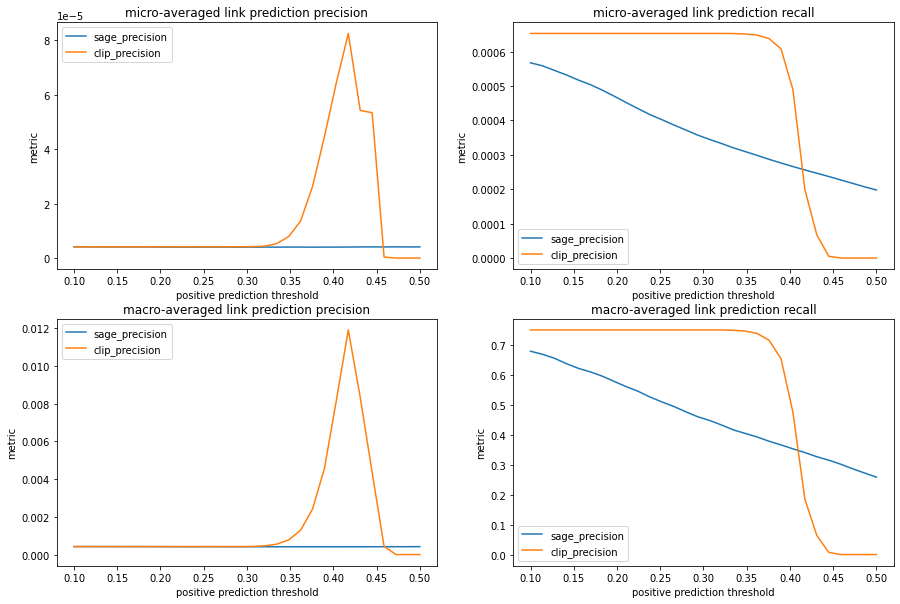

In [21]:
import matplotlib.pyplot as plt

sage_micro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='sage'][['threshold', 'precision_micro', 'recall_micro']]
clip_micro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='clip'][['threshold', 'precision_micro', 'recall_micro']]
sage_macro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='sage'][['threshold', 'precision_macro', 'recall_macro']]
clip_macro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='sage'][['threshold', 'precision_macro', 'recall_macro']]

fig, axs = plt.subplots(2, 2, figsize=(15,10))
for i, avg_type in enumerate(['micro', 'macro']):
    legend = []
    for j, metric in enumerate(['precision', 'recall']):
        for method in ['sage', 'clip']:
            axs[i,j].plot(sage_clip_metrics[sage_clip_metrics['method']==method]['threshold'], 
                    sage_clip_metrics[sage_clip_metrics['method']==method][f'{metric}_{avg_type}'])
            legend += [f'{method}_{metric}']
        axs[i,j].legend(legend)
        axs[i,j].set_xlabel('positive prediction threshold')
        axs[i,j].set_ylabel('metric')
        axs[i,j].set_title(f'{avg_type}-averaged link prediction {metric}')
plt.show()


# Evaluation on Holdout Set
### (Zillow Only)


In [82]:
cfg = NestedNamespace(yaml.load(open('conf/config.yaml'), Loader=Loader))
val_csv_dataset_root = cfg.graph.zillow_val.graph_dir

test_modal_node_ids_file = os.path.join(val_csv_dataset_root,'modal_node_ids.json')
test_new_old_node_id_mapping_file = os.path.join(val_csv_dataset_root,'new_old_node_id_mapping.json')
test_datamodule = DataModule(
    val_csv_dataset_root, 
    modal_node_ids_file, 
    keyword_as_src=False, 
    device=device, 
    batch_size=cfg.training.batch_size, 
    force_reload=False
)

Done loading data from cached files.


In [111]:
test_subgraph = test_datamodule.g_bid
test_eval_subgraph = datamodule.g_bid.subgraph(datamodule.g_bid.nodes())
test_eval_subgraph.ndata['test_mask'] = torch.zeros(len(test_eval_subgraph.nodes()), dtype=torch.uint8).to(device)
print(len(test_eval_subgraph.ndata['test_mask']))

test_img_node_idxs = (test_subgraph.ndata['ntype'] == 0).nonzero().squeeze()
test_img_embeds = test_subgraph.ndata['feat'][test_img_node_idxs]
test_img_node_ids = test_subgraph.nodes()[test_img_node_idxs] + torch.max(test_eval_subgraph.nodes()) + 1

print('number of test img nodes:', len(test_img_node_ids))
print('number of "train" img nodes:', len(test_eval_subgraph.nodes()))

test_nodes_data = {'train_mask': torch.zeros(len(test_img_node_ids), dtype=torch.uint8).to(device),
                   'val_mask': torch.zeros(len(test_img_node_ids), dtype=torch.uint8).to(device),
                   'test_mask': torch.ones(len(test_img_node_ids), dtype=torch.uint8).to(device),
                   'ntype': torch.zeros(len(test_img_node_ids), dtype=torch.int64).to(device),
                   'feat': test_img_embeds.to(device),
                   '_ID': test_img_node_ids}

test_eval_subgraph.add_nodes(num=len(test_img_node_ids), data=test_nodes_data)

84270
number of test img nodes: 9206
number of "train" img nodes: 84270


In [112]:
if reconnection_method == 'cosine':
    # Step 3: Identify image node pairs as edges

    eval_train_img_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 0)&(test_eval_subgraph.ndata['test_mask']==0)).nonzero().squeeze()
    eval_train_kw_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 1)&(test_eval_subgraph.ndata['test_mask']==0)).nonzero().squeeze()
    eval_test_img_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 0)&(test_eval_subgraph.ndata['test_mask']==1)).nonzero().squeeze()
    
    eval_train_img_embeds = test_eval_subgraph.ndata['feat'][eval_train_img_node_idxs]
    eval_train_kw_embeds = test_eval_subgraph.ndata['feat'][eval_train_kw_node_idxs]
    eval_test_img_embeds = test_eval_subgraph.ndata['feat'][eval_test_img_node_idxs]

    cosine_sims_img_matrix = cosine_sim(eval_test_img_embeds, eval_train_img_embeds)
    cosine_sims_img_kw_matrix = cosine_sim(eval_test_img_embeds, eval_train_kw_embeds)
    print(eval_test_img_embeds.size())
    print(cosine_sims_img_matrix.size())

    img_sim_threshold = 0.98
    img_img_k = 5
    img_kw_k = 5
            
    test_eval_matches = []
    for i in tqdm(range(cosine_sims_img_matrix.size(0)), desc='computing image-image matches'):
        # get val img to train img matches
        eval_train_img_node_id_matches = eval_train_img_node_idxs[(cosine_sims_img_matrix[i]>img_sim_threshold)]

        if len(eval_train_img_node_id_matches) < img_img_k:
            img_matches, img_match_indices = torch.topk(cosine_sims_img_matrix[i], img_img_k)
            eval_train_img_node_id_matches = eval_train_img_node_idxs[img_match_indices]
        
        # get val img to train keyword matches
        kw_matches, kw_match_indices = torch.topk(cosine_sims_img_kw_matrix[i], img_kw_k)
        
        eval_train_kw_node_id_matches = eval_train_kw_node_idxs[kw_match_indices]

        eval_train_node_id_matches = torch.cat((eval_train_img_node_id_matches, eval_train_kw_node_id_matches))
        matches.append(eval_train_node_id_matches.tolist())

    test_matches_per_img = [len(match_list) for match_list in test_eval_matches]


elif reconnection_method == 'scene':
    # Step 3: Identify image and scene node pairs as edges

    eval_train_img_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 0)&(test_eval_subgraph.ndata['test_mask']==0)).nonzero().squeeze()
    eval_train_scene_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 2)&(test_eval_subgraph.ndata['test_mask']==0)).nonzero().squeeze()

    eval_test_img_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 0)&(test_eval_subgraph.ndata['test_mask']==1)).nonzero().squeeze()
    eval_test_scene_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 2)&(test_eval_subgraph.ndata['test_mask']==1)).nonzero().squeeze()

    eval_train_img_ids = test_eval_subgraph.ndata['_ID'][eval_train_img_node_idxs]
    eval_train_scene_ids = test_eval_subgraph.ndata['_ID'][eval_train_scene_node_idxs]

    eval_test_img_ids = test_eval_subgraph.ndata['_ID'][eval_test_img_node_idxs]
    eval_test_scene_ids = test_eval_subgraph.ndata['_ID'][eval_test_scene_node_idxs]

    def get_scene_edges(node_id, input_graph=datamodule.g_bid, eval_train_scene_ids=eval_train_scene_ids):
        u_node, v_node = input_graph.edges()

        u_node_edge_idxs = torch.nonzero(node_id == u_node)
        v_ids = v_node[u_node_edge_idxs]

        v_node_edge_idxs = torch.nonzero(node_id == v_node)
        u_ids = u_node[v_node_edge_idxs]

        all_edge_ids = torch.cat([u_ids, v_ids], dim=0)

        indices = torch.zeros_like(all_edge_ids, dtype = torch.uint8, device = device)
        for elem in eval_train_scene_ids:
            indices = indices | (all_edge_ids == elem)  

        intersection = all_edge_ids[indices] 

        return torch.unique(intersection)

torch.Size([9206, 512])
torch.Size([9206, 82720])


computing image-image matches: 100%|██████████| 9206/9206 [00:02<00:00, 4440.35it/s]


In [113]:
if reconnection_method == 'cosine':

    # Step 4: Add the edges to eval_subgraph

    u_test = []
    v_test = []

    for i in range(len(test_eval_matches)):
        test_img_node = eval_test_img_node_idxs[i].item()
        train_matches = test_eval_matches[i]
        for node_id in train_matches:
            train_img_node = node_id
            # Add bidirectional edge for each match
            u_test += [test_img_node, train_img_node]
            v_test += [train_img_node, test_img_node]

elif reconnection_method == 'scene':
    
    ## every eval-validation image:
    ##### find all eval-train scenes it is connected to in the eval_subgraph
    ##### connect the image-scene 

    u_test = []
    v_test = []

    for eval_test_img_id in tqdm(eval_test_img_ids):
        matching_eval_train_scenes = get_scene_edges(eval_test_img_id, 
                                                    input_graph=datamodule.g_bid, 
                                                    eval_train_scene_ids=eval_train_scene_ids)
        
        if matching_eval_train_scenes.size(dim=0) > 0:
            for scene in matching_eval_train_scenes:
                u_test += [eval_test_img_id.item(), scene.item()]
                v_test += [scene.item(), eval_val_img_id.item()]


test_edge_data = {'_ID': torch.arange(torch.max(test_eval_subgraph.edata['_ID'])+1, torch.max(test_eval_subgraph.edata['_ID'])+1+len(u), dtype=torch.int64).to(device)}
test_eval_subgraph.add_edges(torch.LongTensor(u_test).to(device), torch.LongTensor(v_test).to(device), data=test_edge_data)
test_eval_subgraph = test_eval_subgraph.add_self_loop()

In [114]:
# Step 5: Turn DGL graph into DataLoader object for GraphSAGE forward inference

u_test_eval, v_test_eval = test_eval_subgraph.edges()
test_eval_subgraph_eids = test_eval_subgraph.edge_ids(u_test_eval, v_test_eval)
layer_sampler = dgl.dataloading.NeighborSampler(fanouts=[10, 25]) # During message passing between GNN layers, each node accept messages from a maximum of 25 incoming nodes
batch_size = len(test_eval_subgraph_eids)

def test_eval_dataloader(g, layer_sampler, batch_size, eids):
    edge_sampler = dgl.dataloading.as_edge_prediction_sampler(layer_sampler)

    return dgl.dataloading.DataLoader(
        g,
        eids,
        edge_sampler,
        device=device,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
        # num_workers=self.num_workers,
    )

test_eval_dl = test_eval_dataloader(test_eval_subgraph, layer_sampler, batch_size, test_eval_subgraph_eids)

In [115]:
# Step 6: Run graphSAGE forward inference over entire val_subgraph message flow graph (MFG)

for batch in test_eval_dl:
    # This loop only runs once b/c batch_size = number of total edges in train_val_subgraph - we only need it to get "blocks"
    test_inputs, test_edge_subgraph, test_blocks = batch
    
x = test_blocks[0].srcdata["feat"]
model = model.to(device)
logits = model.module(test_blocks, x)

test_eval_subgraph.ndata['feat_pred'] = logits

In [126]:
# Step 7: Extract validation image features and keyword features for 
eval_test_img_node_ids = ((test_eval_subgraph.ndata['test_mask']==1)&(test_eval_subgraph.ndata['ntype']==0)).nonzero().squeeze()
eval_keyword_node_ids = ((test_eval_subgraph.ndata['ntype']==1)).nonzero().squeeze()

test_keyword_ids = test_subgraph.nodes()[(test_subgraph.ndata['ntype']==1).nonzero().squeeze()].cpu().detach().tolist()
test_new_old_node_id_mapping = json.load(open(test_new_old_node_id_mapping_file, 'r'))
test_keyword_hashes = [test_new_old_node_id_mapping[str(key)] for key in test_keyword_ids]

train_new_old_node_id_mapping_file = os.path.join(csv_dataset_root,'new_old_node_id_mapping.json')
train_new_old_node_id_mapping = json.load(open(train_new_old_node_id_mapping_file, 'r'))
train_keyword_hashes = [train_new_old_node_id_mapping[str(key.item())] for key in eval_keyword_node_ids]

train_overlap_ids = []
for i in range(len(train_keyword_hashes)):
    if train_keyword_hashes[i] in test_keyword_hashes:
        train_overlap_ids.append(eval_keyword_node_ids[i])
eval_test_keyword_node_ids = torch.LongTensor(train_overlap_ids)

test_overlap_ids = []
for i in range(len(test_keyword_hashes)):
    if test_keyword_hashes[i] in train_keyword_hashes:
        test_overlap_ids.append(test_keyword_ids[i])
test_keyword_node_ids = torch.LongTensor(test_overlap_ids)

# Post-GraphSAGE embeddings
eval_test_img_feat_sage = test_eval_subgraph.ndata['feat_pred'][eval_test_img_node_ids]
eval_keyword_feat_sage = test_eval_subgraph.ndata['feat_pred'][eval_test_keyword_node_ids]

# Original CLIP embeddings before GraphSAGE forward method
eval_test_img_feat_clip = test_eval_subgraph.ndata['feat'][eval_test_img_node_ids]
eval_keyword_feat_clip = test_eval_subgraph.ndata['feat'][eval_test_keyword_node_ids]

In [132]:
verbose = False

# Step 8: Compute cosine similarities between validation images and keywords to get "link scores" between 0 and 1

test_sage_link_scores = cosine_sim(eval_keyword_feat_sage, eval_test_img_feat_sage).cpu().detach().numpy()
test_clip_link_scores = cosine_sim(eval_keyword_feat_clip, eval_test_img_feat_clip).cpu().detach().numpy()

if verbose:
    print('means:')
    print('sage:', np.mean(val_sage_link_scores))
    print('clip:', np.mean(val_clip_link_scores))
    print('mins:')
    print('sage:', np.min(val_sage_link_scores))
    print('clip:', np.min(val_clip_link_scores))
    print('maxs:')
    print('sage:', np.max(val_sage_link_scores))
    print('clip:', np.max(val_clip_link_scores))
    print('stds:')
    print('sage:', np.std(val_sage_link_scores))
    print('clip:', np.std(val_clip_link_scores))

In [140]:
# Step 9: Get true labels for each keyword from validation subgraph adjacency matrix
# Adjacency matrix needs to be sub-setted such that rows correspond only to image nodes and columns correspond only to keyword nodes
test_img_indices = (test_subgraph.ndata['ntype']==0).nonzero().cpu().reshape(1, -1)
test_keyword_indices = test_keyword_node_ids.reshape(-1, 1)

test_adj_matrix = test_subgraph.adjacency_matrix().to_dense().numpy()
test_adj_matrix = test_adj_matrix[test_keyword_indices, test_img_indices]
print(test_adj_matrix.shape)

# Step 10: Make predictions based on prediction threshold and get precision, recall, and accuracy 
pred_thresholds = np.linspace(0.1, 0.9, 50)
test_sage_clip_metrics = pd.DataFrame()

for pred_threshold in pred_thresholds:
    test_sage_link_predictions = (test_sage_link_scores > pred_threshold).astype(int)
    test_clip_link_predictions = (test_clip_link_scores > pred_threshold).astype(int)

    results_dict = {'sage': {'tp': np.empty(len(test_sage_link_predictions)),
                             'fp': np.empty(len(test_sage_link_predictions)),
                             'fn': np.empty(len(test_sage_link_predictions)),
                             'actual_p': np.empty(len(test_sage_link_predictions)),
                             'precision': np.empty(len(test_sage_link_predictions)),
                             'recall': np.empty(len(test_sage_link_predictions))},
                    'clip': {'tp': np.empty(len(test_clip_link_predictions)),
                             'fp': np.empty(len(test_clip_link_predictions)),
                             'fn': np.empty(len(test_clip_link_predictions)),
                             'actual_p': np.empty(len(test_clip_link_predictions)),
                             'precision': np.empty(len(test_clip_link_predictions)),
                             'recall': np.empty(len(test_clip_link_predictions))}}

    weights = np.empty(len(test_sage_link_predictions))

    for i in range(len(test_sage_link_predictions)):
        sage_tp = np.sum(((test_sage_link_predictions[i]==1)&(test_adj_matrix[i]==1)))
        sage_fp = np.sum(((test_sage_link_predictions[i]==1)&(test_adj_matrix[i]==0)))
        sage_fn = np.sum(((test_sage_link_predictions[i]==0)&(test_adj_matrix[i]==1)))
        sage_p = np.sum(test_sage_link_predictions[i])
        
        clip_tp = np.sum(((test_clip_link_predictions[i]==1)&(test_adj_matrix[i]==1)))
        clip_fp = np.sum(((test_clip_link_predictions[i]==1)&(test_adj_matrix[i]==0)))
        clip_fn = np.sum(((test_clip_link_predictions[i]==0)&(test_adj_matrix[i]==1)))
        clip_p = np.sum(test_clip_link_predictions[i])

        true_p = np.sum(test_adj_matrix[i])
        
        results_dict['sage']['tp'][i] = sage_tp
        results_dict['sage']['fp'][i] = sage_fp
        results_dict['sage']['fn'][i] = sage_fn
        results_dict['sage']['actual_p'][i] = true_p
        results_dict['sage']['precision'][i] = sage_tp / sage_p if sage_p > 0 else 0
        results_dict['sage']['recall'][i] = sage_tp / true_p if true_p > 0 else 0

        results_dict['clip']['tp'][i] = clip_tp
        results_dict['clip']['fp'][i] = clip_fp
        results_dict['clip']['fn'][i] = clip_fn
        results_dict['clip']['actual_p'][i] = true_p
        results_dict['clip']['precision'][i] = clip_tp / clip_p if clip_p > 0 else 0
        results_dict['clip']['recall'][i] = clip_tp / true_p if true_p > 0 else 0

        weights[i] = true_p

    weights /= np.sum(weights)

    for method in results_dict.keys():
        row = {'threshold': pred_threshold, 'method': method}
        for metric in results_dict[method]:
            if metric == 'precision' or metric == 'recall':
                row[f'{metric}_micro'] = np.mean(results_dict[method][metric]*weights)
                row[f'{metric}_macro'] = np.mean(results_dict[method][metric])
            else:
                row[metric] = np.mean(results_dict[method][metric])
        test_sage_clip_metrics = pd.concat([test_sage_clip_metrics, pd.DataFrame([row])], ignore_index=True)

test_sage_metrics = test_sage_clip_metrics[(test_sage_clip_metrics['method']=='sage')]
test_clip_metrics = test_sage_clip_metrics[(test_sage_clip_metrics['method']=='clip')]

(10, 9206)


In [141]:
print('Best SAGE metrics: ')
print('Precision, Recall at Max Recall:\n', test_sage_metrics[test_sage_metrics['recall_macro']==test_sage_metrics['recall_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])
print('Precision, Recall at Max Precision:\n', test_sage_metrics[test_sage_metrics['precision_macro']==test_sage_metrics['precision_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])

print('Best CLIP metrics: ')
print('Precision, Recall at Max Recall:\n', test_clip_metrics[test_clip_metrics['recall_macro']==test_clip_metrics['recall_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])
print('Precision, Recall at Max Precision:\n', test_clip_metrics[test_clip_metrics['precision_macro']==test_clip_metrics['precision_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])

Best SAGE metrics: 
Precision, Recall at Max Recall:
 threshold          0.100000
precision_macro    0.131748
recall_macro       0.999677
Name: 0, dtype: float64
Precision, Recall at Max Precision:
 threshold          0.655102
precision_macro    0.354347
recall_macro       0.523020
Name: 68, dtype: float64
Best CLIP metrics: 
Precision, Recall at Max Recall:
 threshold          0.100000
precision_macro    0.131197
recall_macro       1.000000
Name: 1, dtype: float64
Precision, Recall at Max Precision:
 threshold          0.410204
precision_macro    0.400624
recall_macro       0.162507
Name: 39, dtype: float64


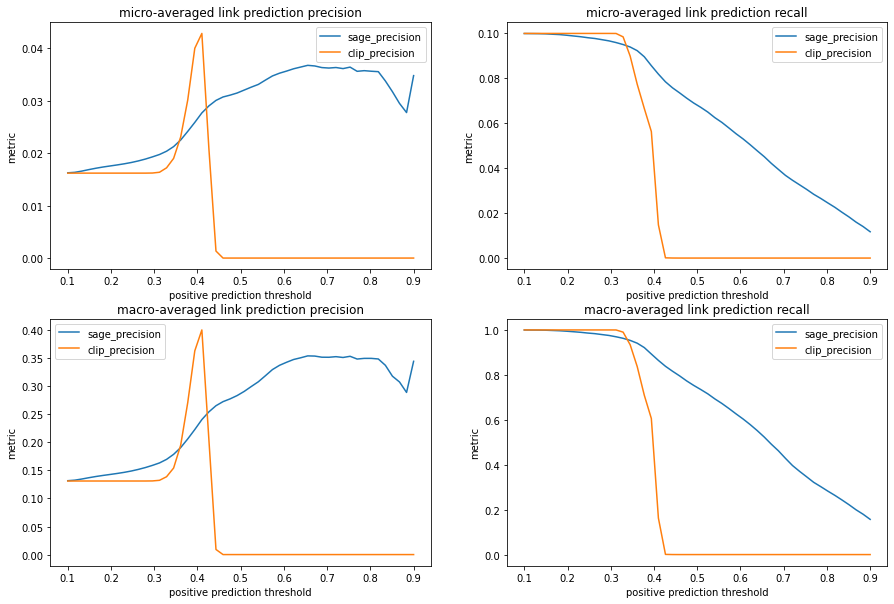

In [142]:
import matplotlib.pyplot as plt

# test_sage_micro_threshold_metrics = test_sage_clip_metrics[test_sage_clip_metrics['method']=='sage'][['threshold', 'precision_micro', 'recall_micro']]
# test_clip_micro_threshold_metrics = test_sage_clip_metrics[test_sage_clip_metrics['method']=='clip'][['threshold', 'precision_micro', 'recall_micro']]
# test_sage_macro_threshold_metrics = test_sage_clip_metrics[test_sage_clip_metrics['method']=='sage'][['threshold', 'precision_macro', 'recall_macro']]
# test_clip_macro_threshold_metrics = test_sage_clip_metrics[test_sage_clip_metrics['method']=='sage'][['threshold', 'precision_macro', 'recall_macro']]

fig, axs = plt.subplots(2, 2, figsize=(15,10))
for i, avg_type in enumerate(['micro', 'macro']):
    legend = []
    for j, metric in enumerate(['precision', 'recall']):
        for method in ['sage', 'clip']:
            axs[i,j].plot(test_sage_clip_metrics[test_sage_clip_metrics['method']==method]['threshold'], 
                    test_sage_clip_metrics[test_sage_clip_metrics['method']==method][f'{metric}_{avg_type}'])
            legend += [f'{method}_{metric}']
        axs[i,j].legend(legend)
        axs[i,j].set_xlabel('positive prediction threshold')
        axs[i,j].set_ylabel('metric')
        axs[i,j].set_title(f'{avg_type}-averaged link prediction {metric}')
plt.show()


##### Additional Analysis

In [ ]:
# Side quest: check out how nodes with only self loops change in terms of their embeddings after running graphSAGE forward

eval_subgraph_keyword_nodes = (eval_subgraph.ndata['ntype']==1).nonzero().squeeze()
u, v = eval_subgraph.edges()
uv = torch.cat((u,v))

only_self_loops = []
for node in tqdm(eval_subgraph_keyword_nodes):
    count = torch.sum((uv==node))
    if count == 2:
        only_self_loops.append(node.item())

print(eval_subgraph.ndata['feat_norm'][only_self_loops[0]][:10])
print(eval_subgraph.ndata['feat_pred_norm'][only_self_loops[0]][:10])
